In [2]:
import pysr
import sympy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
from pysr import PySRRegressor
from sklearn. model_selection import train_test_split
from scipy import special
from scipy.special import erf, erfc
import pandas as pd
from scipy.integrate import quad
from scipy.interpolate import interp1d
import matplotlib.lines as mlines
from matplotlib import rc
from matplotlib.ticker import LogFormatter

plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

# Dataset
base_path = "/Users/yuangw/Documents/GitHub/GBF/multispin/"  # Use relative path
GBF_10_10 = np.loadtxt(base_path + "GBF_s=1_l=1.txt")
GBF_10_20 = np.loadtxt(base_path + "GBF_s=1_l=2.txt")
GBF_10_30 = np.loadtxt(base_path + "GBF_s=1_l=3.txt")
GBF_10_40 = np.loadtxt(base_path + "GBF_s=1_l=4.txt")
s10x, s10l0, s10l1, s10l2, s10l3 = GBF_10_10[:, 0], GBF_10_10[:, 1], GBF_10_20[:, 1], GBF_10_30[:, 1], GBF_10_40[:, 1]
np.savetxt("multispin/GBF_s=10.txt", np.c_[s10x, s10l0, s10l1, s10l2, s10l3])
s10_array = np.column_stack((s10l0, s10l1, s10l2, s10l3))

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## 10% noise level in both $\Omega_i$ and $\Gamma_i$

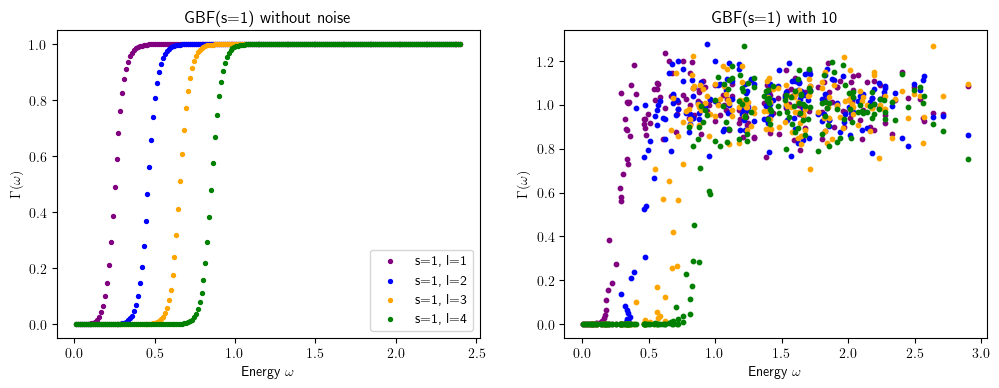

In [22]:
# Define Gaussian noise
mean = 0 
std_dev10 = 0.1  # 10% noise level in both omega and GBF
s10x_noise10 = s10x + np.random.normal(mean, std_dev10*s10x)
y1_noise10 = s10l0 + np.random.normal(mean, std_dev10*s10l0, size=s10l0.shape)
y2_noise10 = s10l1 + np.random.normal(mean, std_dev10*s10l1, size=s10l1.shape)
y3_noise10 = s10l2 + np.random.normal(mean, std_dev10*s10l2, size=s10l2.shape)
y4_noise10 = s10l3 + np.random.normal(mean, std_dev10*s10l3, size=s10l3.shape)
y_noise10 = np.column_stack((y1_noise10, y2_noise10, y3_noise10, y4_noise10)) # from (100, 1) to (100,4)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(s10x, s10l0, color= 'purple', s=8, label='s=1, l=1')
axs[0].scatter(s10x, s10l1, color= 'blue', s=8, label='s=1, l=2')
axs[0].scatter(s10x, s10l2, color= 'orange', s=8, label='s=1, l=3')
axs[0].scatter(s10x, s10l3, color= 'green', s=8, label='s=1, l=4')
axs[0].set_xlabel("Energy $\omega$")
axs[0].set_ylabel("$\Gamma (\omega)$")
axs[0].set_title("GBF(s=1) without noise")
axs[0].legend()

axs[1].scatter(s10x_noise10, y_noise10[:, 0], color='purple', marker='o', s=10)
axs[1].scatter(s10x_noise10, y_noise10[:, 1], color='blue', marker='o', s=10)
axs[1].scatter(s10x_noise10, y_noise10[:, 2], color='orange', marker='o', s=10)
axs[1].scatter(s10x_noise10, y_noise10[:, 3], color='green', marker='o', s=10)
axs[1].set_xlabel("Energy $\omega$")
axs[1].set_ylabel("$\Gamma (\omega)$")
axs[1].set_title("GBF(s=1) with 10% Gaussian noise")
# axs[1].legend()

plt.show()

### PySR for 10% errorbar

In [4]:
# Step 1: Generate sample data
l_values = np.array([1, 2, 3, 4])
x_grid, l_grid = np.meshgrid(s10x_noise10, l_values, indexing='ij')

# Step 2: Flatten the grid to create a dataset with shape (100*4, 2)
x_flat = x_grid.flatten()  # shape (400, )
l_flat = l_grid.flatten()  # shape (400, )
input_data = np.column_stack((x_flat, l_flat))  # Shape: (400, 2)

y_flat = y_noise10.flatten()

print(np.shape(input_data), np.shape(y_noise10), np.shape(y_flat))

# Step 4: Set up and run the PySR symbolic regression
SchGBF_model10 = PySRRegressor(
    niterations=500,
    binary_operators = ["+", "-", "*", "/"],
    unary_operators = ["sin", "cos", "exp", "log", "erf", "erfc"], # round/ceil/floor are Optional for discrete handling
    complexity_of_operators={"+": 1, "-": 1,"*": 2, "/": 2, "sin": 3, "cos": 3, "exp": 3, "log": 3, "erf": 4,"erfc": 4}, # set custom complexities
)

# Step 5: Fit the model
SchGBF_model10.fit(input_data, y_flat)

(800, 2) (200, 4) (800,)
Compiling Julia backend...


/Users/yuangw/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.760e+05
Head worker occupation: 8.0%
Progress: 657 / 7500 total iterations (8.760%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.219e+00  1.594e+01  y = 1.7933
3           1.721e-01  9.787e-01  y = 0.24442 - -0.52583
4           6.925e-02  9.105e-01  y = sin(x₀)
5           5.949e-02  1.519e-01  y = erf(x₀)
7           5.861e-02  7.393e-03  y = erf(-0.048773 + x₀)
9           5.733e-02  1.112e-02  y = erf(-0.10905 + x₀) + 0.052298
10          5.223e-02  9.310e-02  y = erf((x₀ + x₀) / x₁)
11          4.330e-02  1.875e-01  y = erf((x₀ / x₁) * 2.6541)
12          4.031e-02  7.142e-02  y = erf(x₀ - (0.2666 - (x₀ / x₁)))
13          1.620e-02  9.116e-01  y = erf(exp(3.8543 - (x₁ / x₀)))
15          1.423e-02  6.471e-02  y = erf(exp(x₀ - ((x₁ / x₀) + -3.1532)))
17          1.406e-02  6.346e-03  y = erf(exp(x₀ + (3.3218 - ((0.10408 +

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                         0.77025515   
	1         2.905153e-08                             0.2444203 - -0.5258347   
	2         9.104519e-01                                            sin(x0)   
	3         1.518967e-01                                            erf(x0)   
	4         7.393396e-03                             erf(x0 + -0.048790358)   
	5         1.111886e-02               erf(-0.10911231 + x0) - -0.052340183   
	6         9.309625e-02                                erf((x0 + x0) / x1)   
	7         1.875248e-01                         erf((x0 / x1) * 2.6540956)   
	8         1.419365e-01                  erf(((x0 + 3.5247629) - x1) * x0)   
	9   >>>>  8.410836e-01                    erf(exp(3.8542948 - (x1 / x0)))   
	10        6.470707e-02            erf(exp(x0 - ((x1 / x0) + -3.1531675)))   
	11        3.181625e-03               erf(exp(4.2929053 - (x1 / x0)) * x0)   
	12        9.957417e-03  erf(exp(3.3618784 + (x0 - ((x1 - -0.11852405) ...   
	13        2.408486e-02  erf(exp(((3.3053765 + x0) - (x1 / x0)) / 0.714...   
	14        4.721983e-03  erf(x0 * exp((4.2929053 - (x1 / x0)) / 0.71005...   
	15        5.113643e-05  erf(exp(5.5039907 + (x0 - ((x1 + 0.1487724) / ...   
	
	        loss  complexity  
	0   0.172108           1  
	1   0.172108           3  
	2   0.069246           4  
	3   0.059488           5  
	4   0.058615           7  
	5   0.057326           9  
	6   0.052230          10  
	7   0.043299          11  
	8   0.037569          12  
	9   0.016202          13  
	10  0.014235          15  
	11  0.014190          16  
	12  0.014049          17  
	13  0.013715          18  
	14  0.013650          19  
	15  0.013649          20  
]

In [5]:
SchGBF_model10.sympy()

erf(exp(3.8542948 - x1/x0))

### The fitting result of SR with 10%

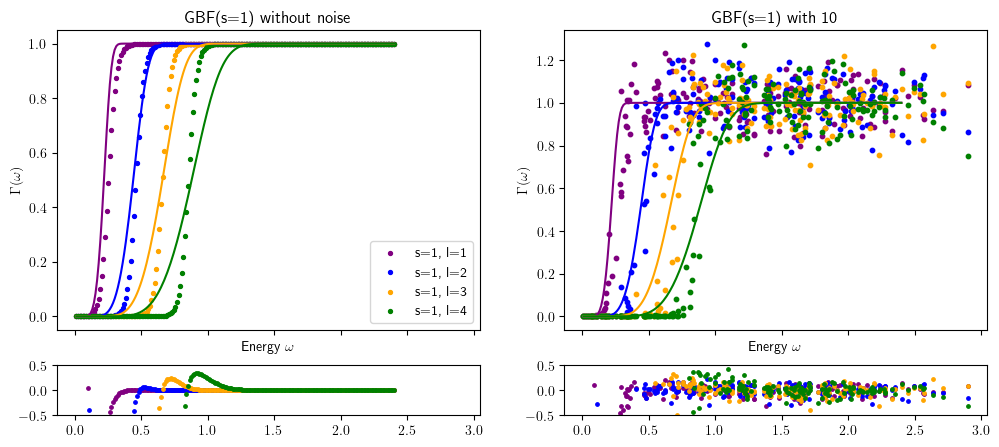

In [23]:
def GBFsr10(x0, x1):
    return erf(np.exp(3.8094 - x1/x0) )

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

axs[0,0].plot(s10x, GBFsr10(s10x, 1), color='purple')
axs[0,0].plot(s10x, GBFsr10(s10x, 2), color='blue')
axs[0,0].plot(s10x, GBFsr10(s10x, 3), color='orange')
axs[0,0].plot(s10x, GBFsr10(s10x, 4), color='green')

axs[0,0].scatter(s10x, s10l0, color= 'purple', s=8, label='s=1, l=1')
axs[0,0].scatter(s10x, s10l1, color= 'blue', s=8, label='s=1, l=2')
axs[0,0].scatter(s10x, s10l2, color= 'orange', s=8, label='s=1, l=3')
axs[0,0].scatter(s10x, s10l3, color= 'green', s=8, label='s=1, l=4')
axs[0,0].set_xlabel("Energy $\omega$")
axs[0,0].set_ylabel("$\Gamma (\omega)$")
axs[0,0].set_title("GBF(s=1) without noise")
axs[0,0].legend()

axs[1,0].scatter(s10x, (s10l0-GBFsr10(s10x, 1))/s10l0, color='purple', s=6)
axs[1,0].scatter(s10x, (s10l1-GBFsr10(s10x, 2))/s10l1, color='blue', s=6)
axs[1,0].scatter(s10x, (s10l2-GBFsr10(s10x, 3))/s10l2, color='orange', s=6)
axs[1,0].scatter(s10x, (s10l3-GBFsr10(s10x, 4))/s10l3, color='green', s=6)
axs[1,0].set_ylim(-0.5, 0.5)

axs[0,1].plot(s10x, GBFsr10(s10x, 1), color='purple')
axs[0,1].plot(s10x, GBFsr10(s10x, 2), color='blue')
axs[0,1].plot(s10x, GBFsr10(s10x, 3), color='orange')
axs[0,1].plot(s10x, GBFsr10(s10x, 4), color='green')

axs[0,1].scatter(s10x_noise10, y_noise10[:, 0], color='purple', marker='o', s=10)
axs[0,1].scatter(s10x_noise10, y_noise10[:, 1], color='blue', marker='o', s=10)
axs[0,1].scatter(s10x_noise10, y_noise10[:, 2], color='orange', marker='o', s=10)
axs[0,1].scatter(s10x_noise10, y_noise10[:, 3], color='green', marker='o', s=10)
axs[0,1].set_xlabel("Energy $\omega$")
axs[0,1].set_ylabel("$\Gamma (\omega)$")
axs[0,1].set_title("GBF(s=1) with 10% Gaussian noise")

axs[1,1].scatter(s10x_noise10, (y_noise10[:, 0]-GBFsr10(s10x, 1))/y_noise10[:, 0], color='purple', s=6)
axs[1,1].scatter(s10x_noise10, (y_noise10[:, 1]-GBFsr10(s10x, 2))/y_noise10[:, 1], color='blue', s=6)
axs[1,1].scatter(s10x_noise10, (y_noise10[:, 2]-GBFsr10(s10x, 3))/y_noise10[:, 2], color='orange', s=6)
axs[1,1].scatter(s10x_noise10, (y_noise10[:, 3]-GBFsr10(s10x, 4))/y_noise10[:, 3], color='green', s=6)
axs[1,1].set_ylim(-0.5, 0.5)

plt.show()

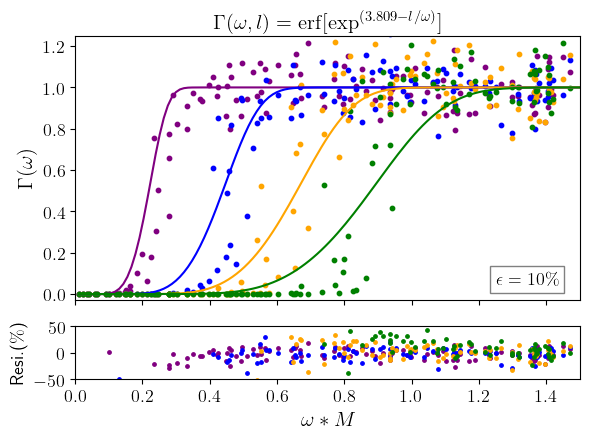

In [8]:
def GBFsr10(x0, x1):
    return erf(np.exp(3.8094 - x1/x0) )

fig, axs = plt.subplots(2, 1, figsize=(6, 4.5), sharex=True, gridspec_kw={'height_ratios': [5, 1]})

axs[0].plot(s10x, GBFsr10(s10x, 1), color='purple')
axs[0].plot(s10x, GBFsr10(s10x, 2), color='blue')
axs[0].plot(s10x, GBFsr10(s10x, 3), color='orange')
axs[0].plot(s10x, GBFsr10(s10x, 4), color='green')

axs[0].scatter(s10x_noise10, y_noise10[:, 0], color='purple', marker='o', s=10)
axs[0].scatter(s10x_noise10, y_noise10[:, 1], color='blue', marker='o', s=10)
axs[0].scatter(s10x_noise10, y_noise10[:, 2], color='orange', marker='o', s=10)
axs[0].scatter(s10x_noise10, y_noise10[:, 3], color='green', marker='o', s=10)
axs[0].set_xlim(0, 1.5)
axs[0].set_ylim(-0.03, 1.25)
axs[0].set_ylabel("$\Gamma (\omega)$", fontsize=15)
axs[0].text(1.25, 0.05, r'$\epsilon=10\%$', fontsize=13, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='square,pad=0.3'))
axs[0].set_title(r'$\Gamma (\omega, l) = {\rm erf}[{\rm exp}^{(3.809 - l/\omega)} ]$', fontsize=15)

axs[1].scatter(s10x_noise10, 100*(y_noise10[:, 0]-GBFsr10(s10x, 1))/y_noise10[:, 0], color='purple', s=6)
axs[1].scatter(s10x_noise10, 100*(y_noise10[:, 1]-GBFsr10(s10x, 2))/y_noise10[:, 1], color='blue', s=6)
axs[1].scatter(s10x_noise10, 100*(y_noise10[:, 2]-GBFsr10(s10x, 3))/y_noise10[:, 2], color='orange', s=6)
axs[1].scatter(s10x_noise10, 100*(y_noise10[:, 3]-GBFsr10(s10x, 4))/y_noise10[:, 3], color='green', s=6)
axs[1].set_xlabel("$\omega*M$", fontsize=15)
axs[1].set_ylabel("Resi.($\%$)", fontsize=13)
axs[1].set_ylim(-50, 50)

axs[1].tick_params('x', labelsize=13)
axs[0].tick_params('y', labelsize=13)
axs[1].tick_params('y', labelsize=13)

plt.tight_layout()
plt.savefig("err10.pdf", bbox_inches='tight')
plt.show()

## 5% noise level in both $\Omega_i$ and $\Gamma_i$

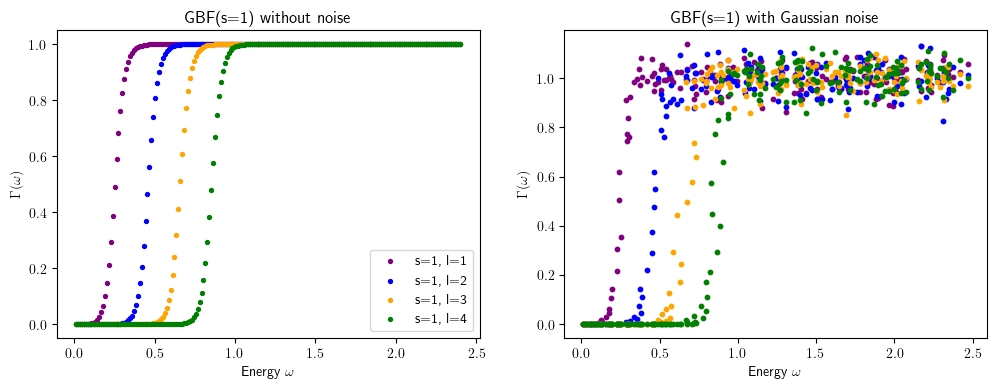

In [24]:
# Define Gaussian noise
mean = 0 
std_dev05 = 0.05  # 1% noise level in both omega and GBF
s10x_noise05 = s10x + np.random.normal(mean, std_dev05*s10x)
y1_noise05 = s10l0 + np.random.normal(mean, std_dev05*s10l0, size=s10l0.shape)
y2_noise05 = s10l1 + np.random.normal(mean, std_dev05*s10l1, size=s10l1.shape)
y3_noise05 = s10l2 + np.random.normal(mean, std_dev05*s10l2, size=s10l2.shape)
y4_noise05 = s10l3 + np.random.normal(mean, std_dev05*s10l3, size=s10l3.shape)
y_noise05 = np.column_stack((y1_noise05, y2_noise05, y3_noise05, y4_noise05)) # from (100, 1) to (100,4)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(s10x, s10l0, color= 'purple', s=8, label='s=1, l=1')
axs[0].scatter(s10x, s10l1, color= 'blue', s=8, label='s=1, l=2')
axs[0].scatter(s10x, s10l2, color= 'orange', s=8, label='s=1, l=3')
axs[0].scatter(s10x, s10l3, color= 'green', s=8, label='s=1, l=4')
axs[0].set_xlabel("Energy $\omega$")
axs[0].set_ylabel("$\Gamma (\omega)$")
axs[0].set_title("GBF(s=1) without noise")
axs[0].legend()

axs[1].scatter(s10x_noise05, y_noise05[:, 0], color='purple', marker='o', s=10)
axs[1].scatter(s10x_noise05, y_noise05[:, 1], color='blue', marker='o', s=10)
axs[1].scatter(s10x_noise05, y_noise05[:, 2], color='orange', marker='o', s=10)
axs[1].scatter(s10x_noise05, y_noise05[:, 3], color='green', marker='o', s=10)
axs[1].set_xlabel("Energy $\omega$")
axs[1].set_ylabel("$\Gamma (\omega)$")
axs[1].set_title("GBF(s=1) with Gaussian noise")
# axs[1].legend()

plt.show()

### PySR for 5% errorbar

In [10]:
# Step 1: Generate sample data
l_values = np.array([1, 2, 3, 4])
x_grid, l_grid = np.meshgrid(s10x_noise05, l_values, indexing='ij')

# Step 2: Flatten the grid to create a dataset with shape (100*4, 2)
x_flat = x_grid.flatten()  # shape (400, )
l_flat = l_grid.flatten()  # shape (400, )
input_data = np.column_stack((x_flat, l_flat))  # Shape: (400, 2)

y_flat = y_noise05.flatten()

# Step 4: Set up and run the PySR symbolic regression
SchGBF_model05 = PySRRegressor(
    niterations=500,
    binary_operators = ["+", "-", "*", "/"],
    unary_operators = ["sin", "cos", "exp", "log", "erf", "erfc"], # round/ceil/floor are Optional for discrete handling
    complexity_of_operators={"+": 1, "-": 1,"*": 2, "/": 2, "sin": 3, "cos": 3, "exp": 3, "log": 3, "erf": 4,"erfc": 4}, # set custom complexities
)

# Step 5: Fit the model
SchGBF_model05.fit(input_data, y_flat)

/Users/yuangw/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.840e+05
Head worker occupation: 8.4%
Progress: 674 / 7500 total iterations (8.987%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.304e-01  1.594e+01  y = x₀
3           1.666e-01  4.745e-01  y = 0.36458 + 0.40551
4           5.783e-02  1.058e+00  y = sin(x₀)
5           5.146e-02  1.168e-01  y = erf(x₀)
7           5.027e-02  1.168e-02  y = erf(-0.057131 + x₀)
9           4.887e-02  1.415e-02  y = erf(x₀ + -0.12744) + 0.058216
10          4.328e-02  1.215e-01  y = erf((x₀ + x₀) / x₁)
11          3.529e-02  2.040e-01  y = erf((x₀ / 0.36334) / x₁)
12          3.252e-02  8.186e-02  y = erf((x₀ + (x₀ / x₁)) - 0.2734)
13          1.033e-02  1.146e+00  y = sin(erfc((x₁ / x₀) - 4.0711))
14          5.127e-03  7.011e-01  y = erf(erfc((x₁ / x₀) - 4.057))
16          3.358e-03  2.116e-01  y = erf(erfc(((x₁ / x₀) - x₀) - 3.3425))
18      

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                           0.770094   
	1         0.352731                                            sin(x0)   
	2         0.116755                                            erf(x0)   
	3         0.011683                              erf(x0 - 0.057135805)   
	4         0.014256                erf(x0 + -0.1199026) - -0.054603554   
	5         0.121308                                erf((x0 + x0) / x1)   
	6         0.211185                         erf((x0 * 2.6211243) / x1)   
	7         0.198638                  erf(x0 * (3.4937315 + (x0 - x1)))   
	8         1.654562          erfc((x1 / x0) + -4.5826006) * 0.50172096   
	9         0.068767                   erf(erfc((x1 / x0) - 4.0570297))   
	10  >>>>  0.352965    erfc((-3.8780077 - x0) + (x1 / x0)) * 0.5019543   
	11        0.079120    erf(erfc(((x1 + 0.35675296) / x0) - 4.6259522))   
	12        0.001566              erf(erfc((x1 / x0) - 3.5236073) * x1)   
	13        0.047567  erf(erfc((((x1 - -0.11296205) / x0) - x0) - 3....   
	14        0.049653      erf((x0 + x0) * erfc(-3.8780077 + (x1 / x0)))   
	
	        loss  complexity  
	0   0.166623           1  
	1   0.057832           4  
	2   0.051459           5  
	3   0.050271           7  
	4   0.048858           9  
	5   0.043276          10  
	6   0.035037          11  
	7   0.028725          12  
	8   0.005492          13  
	9   0.005127          14  
	10  0.003602          15  
	11  0.003328          16  
	12  0.003323          17  
	13  0.003168          18  
	14  0.003015          19  
]

In [10]:
SchGBF_model05.sympy()

erf(erfc(-1*4.112681 + x1/x0))

### The fitting result of SR with 5%

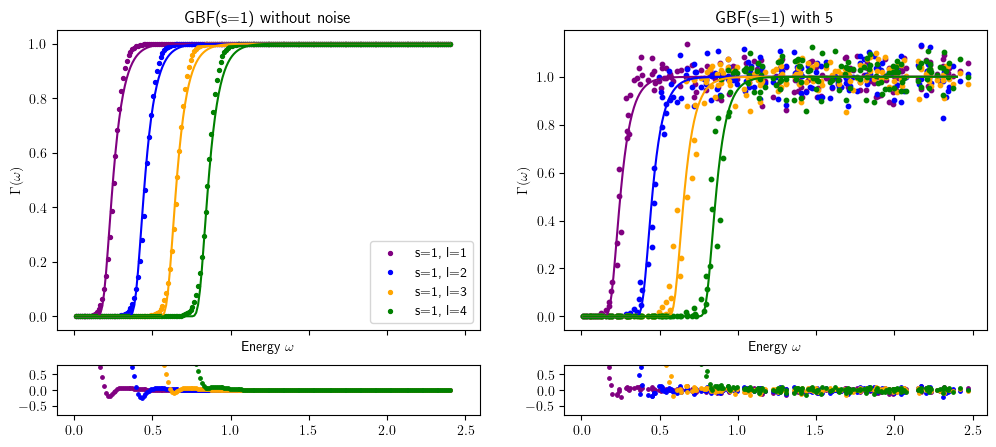

In [25]:
# def GBFsr05(x0, x1):
#     term1 = np.exp((x0/0.2026 - x1 - 0.4964)/0.2640 )
#     return erf( term1 )

def GBFsr05(x0, x1):
    term1 = np.exp(-x0/0.0609 + x1/0.29925 )
    return erfc( term1 )

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

axs[0,0].plot(s10x, GBFsr05(s10x, 1), color='purple')
axs[0,0].plot(s10x, GBFsr05(s10x, 2), color='blue')
axs[0,0].plot(s10x, GBFsr05(s10x, 3), color='orange')
axs[0,0].plot(s10x, GBFsr05(s10x, 4), color='green')

axs[0,0].scatter(s10x, s10l0, color= 'purple', s=8, label='s=1, l=1')
axs[0,0].scatter(s10x, s10l1, color= 'blue', s=8, label='s=1, l=2')
axs[0,0].scatter(s10x, s10l2, color= 'orange', s=8, label='s=1, l=3')
axs[0,0].scatter(s10x, s10l3, color= 'green', s=8, label='s=1, l=4')
axs[0,0].set_xlabel("Energy $\omega$")
axs[0,0].set_ylabel("$\Gamma (\omega)$")
axs[0,0].set_title("GBF(s=1) without noise")
axs[0,0].legend()

axs[1,0].scatter(s10x, (s10l0-GBFsr05(s10x, 1))/s10l0, color='purple', s=6)
axs[1,0].scatter(s10x, (s10l1-GBFsr05(s10x, 2))/s10l1, color='blue', s=6)
axs[1,0].scatter(s10x, (s10l2-GBFsr05(s10x, 3))/s10l2, color='orange', s=6)
axs[1,0].scatter(s10x, (s10l3-GBFsr05(s10x, 4))/s10l3, color='green', s=6)
axs[1,0].set_ylim(-0.8, 0.8)

axs[0,1].plot(s10x, GBFsr05(s10x, 1), color='purple')
axs[0,1].plot(s10x, GBFsr05(s10x, 2), color='blue')
axs[0,1].plot(s10x, GBFsr05(s10x, 3), color='orange')
axs[0,1].plot(s10x, GBFsr05(s10x, 4), color='green')

axs[0,1].scatter(s10x_noise05, y_noise05[:, 0], color='purple', marker='o', s=10)
axs[0,1].scatter(s10x_noise05, y_noise05[:, 1], color='blue', marker='o', s=10)
axs[0,1].scatter(s10x_noise05, y_noise05[:, 2], color='orange', marker='o', s=10)
axs[0,1].scatter(s10x_noise05, y_noise05[:, 3], color='green', marker='o', s=10)
axs[0,1].set_xlabel("Energy $\omega$")
axs[0,1].set_ylabel("$\Gamma (\omega)$")
axs[0,1].set_title("GBF(s=1) with 5% Gaussian noise")

axs[1,1].scatter(s10x_noise05, (y_noise05[:, 0]-GBFsr05(s10x, 1))/y_noise05[:, 0], color='purple', s=6)
axs[1,1].scatter(s10x_noise05, (y_noise05[:, 1]-GBFsr05(s10x, 2))/y_noise05[:, 1], color='blue', s=6)
axs[1,1].scatter(s10x_noise05, (y_noise05[:, 2]-GBFsr05(s10x, 3))/y_noise05[:, 2], color='orange', s=6)
axs[1,1].scatter(s10x_noise05, (y_noise05[:, 3]-GBFsr05(s10x, 4))/y_noise05[:, 3], color='green', s=6)
axs[1,1].set_ylim(-0.8, 0.8)

plt.show()

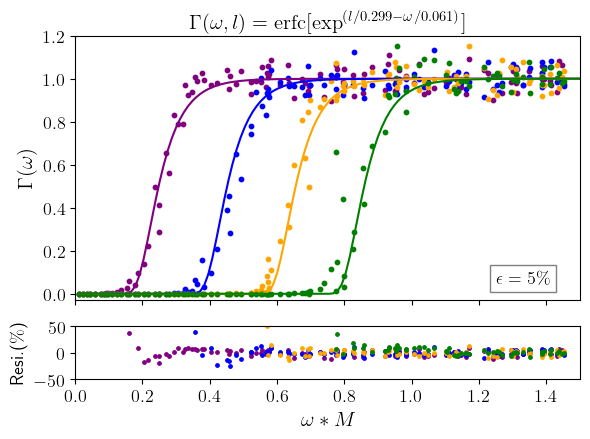

In [11]:
# def GBFsr05(x0, x1):
#     term1 = np.exp((x0/0.2026 - x1 - 0.4964)/0.2640 )
#     return erf( term1 )

def GBFsr05(x0, x1):
    term1 = np.exp(-x0/0.0609 + x1/0.29925 )
    return erfc( term1 )

fig, axs = plt.subplots(2, 1, figsize=(6, 4.5), sharex=True, gridspec_kw={'height_ratios': [5, 1]})

axs[0].plot(s10x, GBFsr05(s10x, 1), color='purple')
axs[0].plot(s10x, GBFsr05(s10x, 2), color='blue')
axs[0].plot(s10x, GBFsr05(s10x, 3), color='orange')
axs[0].plot(s10x, GBFsr05(s10x, 4), color='green')

axs[0].scatter(s10x_noise05, y_noise05[:, 0], color='purple', marker='o', s=10)
axs[0].scatter(s10x_noise05, y_noise05[:, 1], color='blue', marker='o', s=10)
axs[0].scatter(s10x_noise05, y_noise05[:, 2], color='orange', marker='o', s=10)
axs[0].scatter(s10x_noise05, y_noise05[:, 3], color='green', marker='o', s=10)
axs[0].set_xlim(0, 1.5)
axs[0].set_ylim(-0.03, 1.2)
axs[0].set_ylabel("$\Gamma (\omega)$", fontsize=15)
axs[0].text(1.25, 0.05, r'$\epsilon=5\%$', fontsize=13, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='square,pad=0.3'))
axs[0].set_title(r'$\Gamma (\omega, l) = {\rm erfc}[{\rm exp}^{(l/0.299 -\omega /0.061 )} ]$', fontsize=15)

axs[1].scatter(s10x_noise05, 100*(y_noise05[:, 0]-GBFsr05(s10x, 1))/y_noise05[:, 0], color='purple', s=6)
axs[1].scatter(s10x_noise05, 100*(y_noise05[:, 1]-GBFsr05(s10x, 2))/y_noise05[:, 1], color='blue', s=6)
axs[1].scatter(s10x_noise05, 100*(y_noise05[:, 2]-GBFsr05(s10x, 3))/y_noise05[:, 2], color='orange', s=6)
axs[1].scatter(s10x_noise05, 100*(y_noise05[:, 3]-GBFsr05(s10x, 4))/y_noise05[:, 3], color='green', s=6)
axs[1].set_xlabel("$\omega*M$", fontsize=15)
axs[1].set_ylabel("Resi.($\%$)", fontsize=13)
axs[1].set_ylim(-50, 50)

axs[1].tick_params('x', labelsize=13)
axs[0].tick_params('y', labelsize=13)
axs[1].tick_params('y', labelsize=13)

plt.tight_layout()
plt.savefig("err5.pdf", bbox_inches='tight')
plt.show()

## 1% noise level in both $\Omega_i$ and $\Gamma_i$

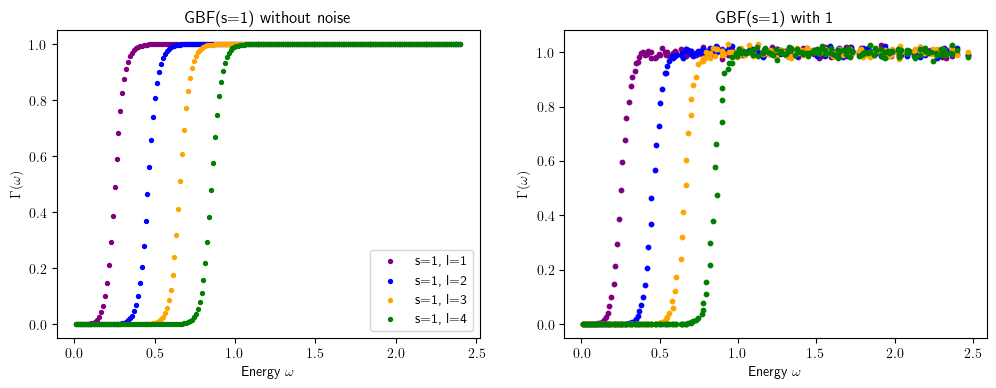

In [26]:
# Define Gaussian noise
mean = 0 
std_dev1 = 0.01  # 1% noise level in both omega and GBF
s10x_noise1 = s10x + np.random.normal(mean, std_dev1*s10x)
y1_noise1 = s10l0 + np.random.normal(mean, std_dev1*s10l0, size=s10l0.shape)
y2_noise1 = s10l1 + np.random.normal(mean, std_dev1*s10l1, size=s10l1.shape)
y3_noise1 = s10l2 + np.random.normal(mean, std_dev1*s10l2, size=s10l2.shape)
y4_noise1 = s10l3 + np.random.normal(mean, std_dev1*s10l3, size=s10l3.shape)
y_noise1 = np.column_stack((y1_noise1, y2_noise1, y3_noise1, y4_noise1)) # from (100, 1) to (100,4)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(s10x, s10l0, color= 'purple', s=8, label='s=1, l=1')
axs[0].scatter(s10x, s10l1, color= 'blue', s=8, label='s=1, l=2')
axs[0].scatter(s10x, s10l2, color= 'orange', s=8, label='s=1, l=3')
axs[0].scatter(s10x, s10l3, color= 'green', s=8, label='s=1, l=4')
axs[0].set_xlabel("Energy $\omega$")
axs[0].set_ylabel("$\Gamma (\omega)$")
axs[0].set_title("GBF(s=1) without noise")
axs[0].legend()

axs[1].scatter(s10x_noise1, y_noise1[:, 0], color='purple', marker='o', s=10)
axs[1].scatter(s10x_noise1, y_noise1[:, 1], color='blue', marker='o', s=10)
axs[1].scatter(s10x_noise1, y_noise1[:, 2], color='orange', marker='o', s=10)
axs[1].scatter(s10x_noise1, y_noise1[:, 3], color='green', marker='o', s=10)
axs[1].set_xlabel("Energy $\omega$")
axs[1].set_ylabel("$\Gamma (\omega)$")
axs[1].set_title("GBF(s=1) with 1% Gaussian noise")
# axs[1].legend()

plt.show()

### PySR for 1% errorbar

In [14]:
 # Step 1: Generate sample data
l_values = np.array([1, 2, 3, 4])
x_grid, l_grid = np.meshgrid(s10x_noise1, l_values, indexing='ij')

# Step 2: Flatten the grid to create a dataset with shape (100*4, 2)
x_flat = x_grid.flatten()  # shape (400, )
l_flat = l_grid.flatten()  # shape (400, )
input_data = np.column_stack((x_flat, l_flat))  # Shape: (400, 2)

y_flat = y_noise1.flatten()

# Step 4: Set up and run the PySR symbolic regression
SchGBF_model1 = PySRRegressor(
    niterations=500,
    binary_operators = ["+", "-", "*", "/"],
    unary_operators = ["sin", "cos", "exp", "log", "erf", "erfc"], # round/ceil/floor are Optional for discrete handling
    complexity_of_operators={"+": 1, "-": 1,"*": 2, "/": 2, "sin": 3, "cos": 3, "exp": 3, "log": 3, "erf": 4,"erfc": 4}, # set custom complexities
)

# Step 5: Fit the model
SchGBF_model1.fit(input_data, y_flat)

/Users/yuangw/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.170e+05
Head worker occupation: 6.0%
Progress: 761 / 7500 total iterations (10.147%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.848e-01  1.594e+01  y = 0.42342
3           1.646e-01  2.739e-01  y = 0.23505 - -0.53494
4           5.614e-02  1.076e+00  y = sin(x₀)
5           5.010e-02  1.139e-01  y = erf(x₀)
7           4.898e-02  1.126e-02  y = erf(x₀ - 0.055308)
8           4.885e-02  2.817e-03  y = sin(x₀ + -0.13311) + 0.086871
9           4.762e-02  2.544e-02  y = 0.053716 + erf(x₀ - 0.11713)
10          4.162e-02  1.346e-01  y = erf((x₀ + x₀) / x₁)
11          3.326e-02  2.242e-01  y = erf((x₀ / x₁) * 2.6453)
12          3.115e-02  6.551e-02  y = erf((x₀ + (x₀ / x₁)) + -0.24363)
13          4.332e-03  1.973e+00  y = erf(exp(3.8183 - (x₁ / x₀)))
15          2.316e-03  3.131e-01  y = erf(exp((3.1229 - (x₁ / x₀)) + x₀))
17 

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.76999474   
	1         0.358621                                            sin(x0)   
	2         0.113873                                            erf(x0)   
	3         0.011261                               erf(x0 - 0.05530839)   
	4         0.002817                sin(x0 + -0.13316713) + 0.086903684   
	5         0.025439                 0.053715866 + erf(x0 - 0.11713316)   
	6         0.134580                                erf((x0 + x0) / x1)   
	7         0.224386                         erf((x0 * 2.6266751) / x1)   
	8         0.225783                  erf(x0 * ((x0 - x1) + 3.4944143))   
	9         1.812485                    erf(exp(3.8183038 - (x1 / x0)))   
	10        0.313055              erf(exp((3.122881 - (x1 / x0)) + x0))   
	11        0.078602              erf(exp((4.008669 - (x1 / x0)) / x0))   
	12        1.224172  erf(exp(9.281737 - ((x1 + (x1 - -0.6420939)) /...   
	13  >>>>  0.606260  erf(exp(((4.8574405 - (x1 / x0)) * x1) + -1.73...   
	14        0.004772  erf(exp(((4.8574405 - (x1 / x0)) * (x1 - -0.02...   
	
	        loss  complexity  
	0   0.164641           1  
	1   0.056143           4  
	2   0.050101           5  
	3   0.048985           7  
	4   0.048847           8  
	5   0.047620           9  
	6   0.041624          10  
	7   0.033258          11  
	8   0.026536          12  
	9   0.004332          13  
	10  0.002316          15  
	11  0.002141          16  
	12  0.000629          17  
	13  0.000343          18  
	14  0.000340          20  
]

In [15]:
SchGBF_model1.sympy()

erf(exp(x1*(4.8574405 - x1/x0) - 1.7363248))

### The fitting result of SR with 1%

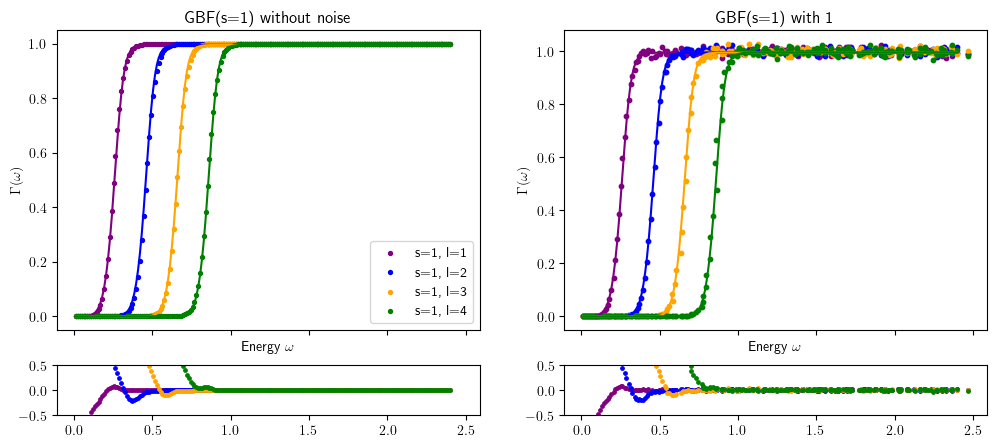

In [27]:
def GBFsr1(x0, x1):
    return erf(erfc(1.097 + 2.059*x1 -10.293*x0 ) )

# def GBFsr1(x0, x1):
#     term1 = np.exp(4.8838*x1 - x1*x1/x0 - 1.7451 )
#     return erf(term1)

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

axs[0,0].plot(s10x, GBFsr1(s10x, 1), color='purple')
axs[0,0].plot(s10x, GBFsr1(s10x, 2), color='blue')
axs[0,0].plot(s10x, GBFsr1(s10x, 3), color='orange')
axs[0,0].plot(s10x, GBFsr1(s10x, 4), color='green')

axs[0,0].scatter(s10x, s10l0, color= 'purple', s=8, label='s=1, l=1')
axs[0,0].scatter(s10x, s10l1, color= 'blue', s=8, label='s=1, l=2')
axs[0,0].scatter(s10x, s10l2, color= 'orange', s=8, label='s=1, l=3')
axs[0,0].scatter(s10x, s10l3, color= 'green', s=8, label='s=1, l=4')
axs[0,0].set_xlabel("Energy $\omega$")
axs[0,0].set_ylabel("$\Gamma (\omega)$")
axs[0,0].set_title("GBF(s=1) without noise")
axs[0,0].legend()

axs[1,0].scatter(s10x, (s10l0-GBFsr1(s10x, 1))/s10l0, color='purple', s=6)
axs[1,0].scatter(s10x, (s10l1-GBFsr1(s10x, 2))/s10l1, color='blue', s=6)
axs[1,0].scatter(s10x, (s10l2-GBFsr1(s10x, 3))/s10l2, color='orange', s=6)
axs[1,0].scatter(s10x, (s10l3-GBFsr1(s10x, 4))/s10l3, color='green', s=6)
axs[1,0].set_ylim(-0.5, 0.5)

axs[0,1].plot(s10x, GBFsr1(s10x, 1), color='purple')
axs[0,1].plot(s10x, GBFsr1(s10x, 2), color='blue')
axs[0,1].plot(s10x, GBFsr1(s10x, 3), color='orange')
axs[0,1].plot(s10x, GBFsr1(s10x, 4), color='green')

axs[0,1].scatter(s10x_noise1, y_noise1[:, 0], color='purple', marker='o', s=10)
axs[0,1].scatter(s10x_noise1, y_noise1[:, 1], color='blue', marker='o', s=10)
axs[0,1].scatter(s10x_noise1, y_noise1[:, 2], color='orange', marker='o', s=10)
axs[0,1].scatter(s10x_noise1, y_noise1[:, 3], color='green', marker='o', s=10)
axs[0,1].set_xlabel("Energy $\omega$")
axs[0,1].set_ylabel("$\Gamma (\omega)$")
axs[0,1].set_title("GBF(s=1) with 1% Gaussian noise")

axs[1,1].scatter(s10x_noise1, (y_noise1[:, 0]-GBFsr1(s10x, 1))/y_noise1[:, 0], color='purple', s=6)
axs[1,1].scatter(s10x_noise1, (y_noise1[:, 1]-GBFsr1(s10x, 2))/y_noise1[:, 1], color='blue', s=6)
axs[1,1].scatter(s10x_noise1, (y_noise1[:, 2]-GBFsr1(s10x, 3))/y_noise1[:, 2], color='orange', s=6)
axs[1,1].scatter(s10x_noise1, (y_noise1[:, 3]-GBFsr1(s10x, 4))/y_noise1[:, 3], color='green', s=6)
axs[1,1].set_ylim(-0.5, 0.5)

plt.show()

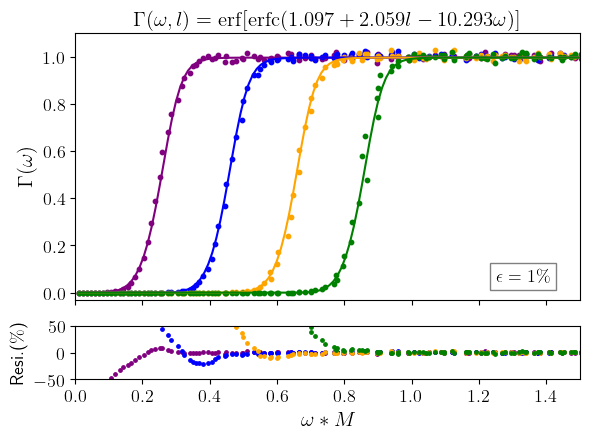

In [28]:
def GBFsr1(x0, x1):
    return erf(erfc(1.097 + 2.059*x1 -10.293*x0 ) )

# def GBFsr1(x0, x1):
#     term1 = np.exp(4.8838*x1 - x1*x1/x0 - 1.7451 )
#     return erf(term1)

fig, axs = plt.subplots(2, 1, figsize=(6, 4.5), sharex=True, gridspec_kw={'height_ratios': [5, 1]})

axs[0].plot(s10x, GBFsr1(s10x, 1), color='purple')
axs[0].plot(s10x, GBFsr1(s10x, 2), color='blue')
axs[0].plot(s10x, GBFsr1(s10x, 3), color='orange')
axs[0].plot(s10x, GBFsr1(s10x, 4), color='green')

axs[0].scatter(s10x_noise1, y_noise1[:, 0], color='purple', marker='o', s=10)
axs[0].scatter(s10x_noise1, y_noise1[:, 1], color='blue', marker='o', s=10)
axs[0].scatter(s10x_noise1, y_noise1[:, 2], color='orange', marker='o', s=10)
axs[0].scatter(s10x_noise1, y_noise1[:, 3], color='green', marker='o', s=10)
axs[0].set_xlim(0, 1.5)
axs[0].set_ylim(-0.03, 1.1)
axs[0].set_ylabel("$\Gamma (\omega)$", fontsize=15)
axs[0].text(1.25, 0.05, r'$\epsilon=1\%$', fontsize=13, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='square,pad=0.3'))
axs[0].set_title(r'$\Gamma (\omega, l) = {\rm erf}[{\rm erfc}(1.097 + 2.059 l -10.293\omega ) ]$', fontsize=15)

axs[1].scatter(s10x_noise1, 100*(y_noise1[:, 0]-GBFsr1(s10x, 1))/y_noise1[:, 0], color='purple', s=6)
axs[1].scatter(s10x_noise1, 100*(y_noise1[:, 1]-GBFsr1(s10x, 2))/y_noise1[:, 1], color='blue', s=6)
axs[1].scatter(s10x_noise1, 100*(y_noise1[:, 2]-GBFsr1(s10x, 3))/y_noise1[:, 2], color='orange', s=6)
axs[1].scatter(s10x_noise1, 100*(y_noise1[:, 3]-GBFsr1(s10x, 4))/y_noise1[:, 3], color='green', s=6)
axs[1].set_xlabel("$\omega*M$", fontsize=15)
axs[1].set_ylabel("Resi.($\%$)", fontsize=13)
axs[1].set_ylim(-50, 50)

axs[1].tick_params('x', labelsize=13)
axs[0].tick_params('y', labelsize=13)
axs[1].tick_params('y', labelsize=13)

plt.tight_layout()
plt.savefig("err1.pdf", bbox_inches='tight')
plt.show()

## 0.1% noise level in both $\Omega_i$ and $\Gamma_i$

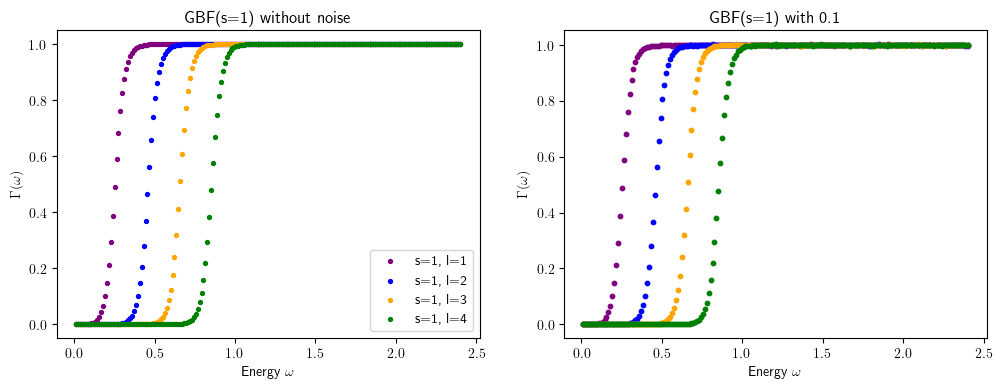

In [29]:
# Define Gaussian noise
mean = 0 
std_dev01 = 0.001  # 10% noise level in both omega and GBF
s10x_noise01 = s10x + np.random.normal(mean, std_dev01*s10x)
y1_noise01 = s10l0 + np.random.normal(mean, std_dev01*s10l0, size=s10l0.shape)
y2_noise01 = s10l1 + np.random.normal(mean, std_dev01*s10l1, size=s10l1.shape)
y3_noise01 = s10l2 + np.random.normal(mean, std_dev01*s10l2, size=s10l2.shape)
y4_noise01 = s10l3 + np.random.normal(mean, std_dev01*s10l3, size=s10l3.shape)
y_noise01 = np.column_stack((y1_noise01, y2_noise01, y3_noise01, y4_noise01)) # from (100, 1) to (100,4)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(s10x, s10l0, color= 'purple', s=8, label='s=1, l=1')
axs[0].scatter(s10x, s10l1, color= 'blue', s=8, label='s=1, l=2')
axs[0].scatter(s10x, s10l2, color= 'orange', s=8, label='s=1, l=3')
axs[0].scatter(s10x, s10l3, color= 'green', s=8, label='s=1, l=4')
axs[0].set_xlabel("Energy $\omega$")
axs[0].set_ylabel("$\Gamma (\omega)$")
axs[0].set_title("GBF(s=1) without noise")
axs[0].legend()

axs[1].scatter(s10x_noise01, y_noise01[:, 0], color='purple', marker='o', s=10)
axs[1].scatter(s10x_noise01, y_noise01[:, 1], color='blue', marker='o', s=10)
axs[1].scatter(s10x_noise01, y_noise01[:, 2], color='orange', marker='o', s=10)
axs[1].scatter(s10x_noise01, y_noise01[:, 3], color='green', marker='o', s=10)
axs[1].set_xlabel("Energy $\omega$")
axs[1].set_ylabel("$\Gamma (\omega)$")
axs[1].set_title("GBF(s=1) with 0.1% Gaussian noise")
# axs[1].legend()

plt.show()

### PySR for 0.1% errorbar

In [18]:
 # Step 1: Generate sample data
l_values = np.array([1, 2, 3, 4])
x_grid, l_grid = np.meshgrid(s10x_noise01, l_values, indexing='ij')

# Step 2: Flatten the grid to create a dataset with shape (100*4, 2)
x_flat = x_grid.flatten()  # shape (400, )
l_flat = l_grid.flatten()  # shape (400, )
input_data = np.column_stack((x_flat, l_flat))  # Shape: (400, 2)

y_flat = y_noise01.flatten()

# Step 4: Set up and run the PySR symbolic regression
SchGBF_model01 = PySRRegressor(
    niterations=500,
    binary_operators = ["+", "-", "*", "/"],
    unary_operators = ["sin", "cos", "exp", "log", "erf", "erfc"], # round/ceil/floor are Optional for discrete handling
    complexity_of_operators={"+": 1, "-": 1,"*": 2, "/": 2, "sin": 3, "cos": 3, "exp": 3, "log": 3, "erf": 4,"erfc": 4}, # set custom complexities
)

# Step 5: Fit the model
SchGBF_model01.fit(input_data, y_flat)

/Users/yuangw/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.100e+05
Head worker occupation: 10.0%
Progress: 717 / 7500 total iterations (9.560%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.085e-01  1.594e+01  y = 1.264
3           1.646e-01  4.545e-01  y = 0.87105 + -0.10089
4           5.615e-02  1.075e+00  y = sin(x₀)
5           5.009e-02  1.142e-01  y = erf(x₀)
7           4.903e-02  1.069e-02  y = erf(x₀ - 0.053853)
8           4.887e-02  3.240e-03  y = sin(x₀ + -0.13176) + 0.08721
9           4.767e-02  2.492e-02  y = erf(x₀ + -0.11555) + 0.053629
10          4.170e-02  1.339e-01  y = erf((x₀ + x₀) / x₁)
11          3.320e-02  2.279e-01  y = erf((x₀ / 0.37981) / x₁)
12          3.085e-02  7.323e-02  y = erf((x₀ + (x₀ / x₁)) - 0.27191)
13          2.270e-02  3.071e-01  y = erf(((x₀ / x₁) / 0.29104) + -0.26892)
14          1.908e-02  1.733e-01  y = erf(((x₀ / x₁) / 0.25487) * x₀)


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          0.7701565   
	1         0.358477                                            sin(x0)   
	2         0.114204                                            erf(x0)   
	3         0.010691                              erf(x0 - 0.053853367)   
	4         0.003240                  sin(x0 - 0.1317675) - -0.08721629   
	5         0.024923                erf(x0 - 0.115542136) + 0.053622406   
	6         0.133898                                erf((x0 + x0) / x1)   
	7         0.227930                        erf((x0 / 0.37980682) / x1)   
	8         0.133857                 erf(x0 * (x0 - (-3.6823757 + x1)))   
	9         1.932307                    erf(exp(3.8319354 - (x1 / x0)))   
	10        0.319618                erf(exp((x0 + 3.1379) - (x1 / x0)))   
	11        0.098132             erf(exp((4.0281568 - (x1 / x0)) / x0))   
	12        0.178112  erf(exp((x0 / 0.09685397) - (1.5471231 + (x1 +...   
	13  >>>>  2.120677  erf(exp((((x0 / 0.2000748) - x1) - 0.51098067)...   
	14        0.025462  erf(-0.008967338 + exp(3.6649275 * (((x0 / 0.2...   
	
	        loss  complexity  
	0   0.164594           1  
	1   0.056151           4  
	2   0.050091           5  
	3   0.049032           7  
	4   0.048873           8  
	5   0.047670           9  
	6   0.041696          10  
	7   0.033198          11  
	8   0.029038          12  
	9   0.004205          13  
	10  0.002219          15  
	11  0.002012          16  
	12  0.001683          17  
	13  0.000202          18  
	14  0.000192          20  
]

In [20]:
SchGBF_model01.sympy()

erf(exp(x1*(4.863819 - x1/x0) - 1*1.7052674))

### The fitting result of SR with 0.1%

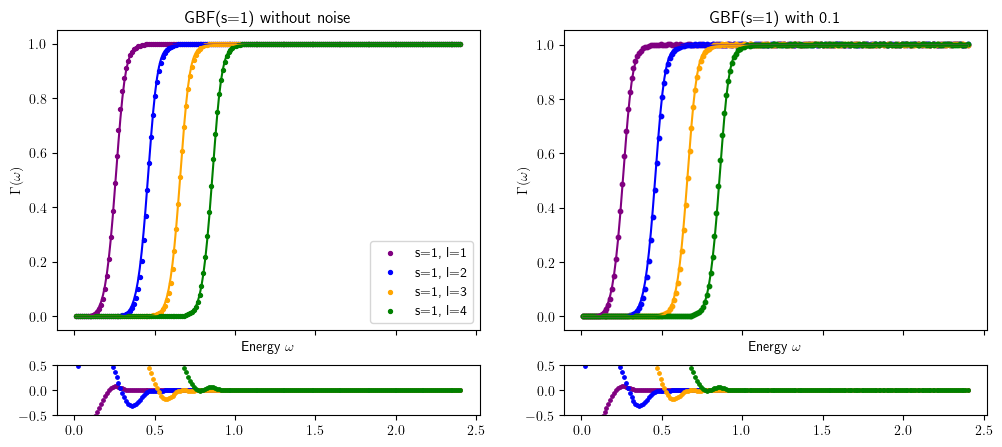

In [30]:
def GBFsr01(x0, x1):
    return erf(erfc (-10.00055*x0 + 2*x1 + 1.08366))

# def GBFsr01(x0, x1):
#     term1 = np.exp(x0/0.0510 - x1/0.2543 - 1.940)
#     return erf (term1)

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

axs[0,0].plot(s10x, GBFsr01(s10x, 1), color='purple')
axs[0,0].plot(s10x, GBFsr01(s10x, 2), color='blue')
axs[0,0].plot(s10x, GBFsr01(s10x, 3), color='orange')
axs[0,0].plot(s10x, GBFsr01(s10x, 4), color='green')

axs[0,0].scatter(s10x, s10l0, color= 'purple', s=8, label='s=1, l=1')
axs[0,0].scatter(s10x, s10l1, color= 'blue', s=8, label='s=1, l=2')
axs[0,0].scatter(s10x, s10l2, color= 'orange', s=8, label='s=1, l=3')
axs[0,0].scatter(s10x, s10l3, color= 'green', s=8, label='s=1, l=4')
axs[0,0].set_xlabel("Energy $\omega$")
axs[0,0].set_ylabel("$\Gamma (\omega)$")
axs[0,0].set_title("GBF(s=1) without noise")
axs[0,0].legend()

axs[1,0].scatter(s10x, (s10l0-GBFsr01(s10x, 1))/s10l0, color='purple', s=6)
axs[1,0].scatter(s10x, (s10l1-GBFsr01(s10x, 2))/s10l1, color='blue', s=6)
axs[1,0].scatter(s10x, (s10l2-GBFsr01(s10x, 3))/s10l2, color='orange', s=6)
axs[1,0].scatter(s10x, (s10l3-GBFsr01(s10x, 4))/s10l3, color='green', s=6)
axs[1,0].set_ylim(-0.5, 0.5)

axs[0,1].plot(s10x, GBFsr01(s10x, 1), color='purple')
axs[0,1].plot(s10x, GBFsr01(s10x, 2), color='blue')
axs[0,1].plot(s10x, GBFsr01(s10x, 3), color='orange')
axs[0,1].plot(s10x, GBFsr01(s10x, 4), color='green')

axs[0,1].scatter(s10x_noise01, y_noise01[:, 0], color='purple', marker='o', s=10)
axs[0,1].scatter(s10x_noise01, y_noise01[:, 1], color='blue', marker='o', s=10)
axs[0,1].scatter(s10x_noise01, y_noise01[:, 2], color='orange', marker='o', s=10)
axs[0,1].scatter(s10x_noise01, y_noise01[:, 3], color='green', marker='o', s=10)
axs[0,1].set_xlabel("Energy $\omega$")
axs[0,1].set_ylabel("$\Gamma (\omega)$")
axs[0,1].set_title("GBF(s=1) with 0.1% Gaussian noise")

axs[1,1].scatter(s10x_noise01, (y_noise01[:, 0]-GBFsr01(s10x, 1))/y_noise01[:, 0], color='purple', s=6)
axs[1,1].scatter(s10x_noise01, (y_noise01[:, 1]-GBFsr01(s10x, 2))/y_noise01[:, 1], color='blue', s=6)
axs[1,1].scatter(s10x_noise01, (y_noise01[:, 2]-GBFsr01(s10x, 3))/y_noise01[:, 2], color='orange', s=6)
axs[1,1].scatter(s10x_noise01, (y_noise01[:, 3]-GBFsr01(s10x, 4))/y_noise01[:, 3], color='green', s=6)
axs[1,1].set_ylim(-0.5, 0.5)

plt.show()

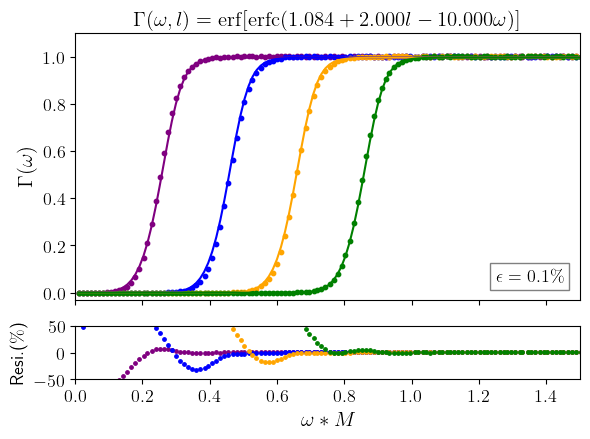

In [20]:
def GBFsr01(x0, x1):
    return erf(erfc (-10.00055*x0 + 2*x1 + 1.08366))

# def GBFsr01(x0, x1):
#     term1 = np.exp(x0/0.0510 - x1/0.2543 - 1.940)
#     return erf (term1)

fig, axs = plt.subplots(2, 1, figsize=(6, 4.5), sharex=True, gridspec_kw={'height_ratios': [5, 1]})

axs[0].plot(s10x, GBFsr01(s10x, 1), color='purple')
axs[0].plot(s10x, GBFsr01(s10x, 2), color='blue')
axs[0].plot(s10x, GBFsr01(s10x, 3), color='orange')
axs[0].plot(s10x, GBFsr01(s10x, 4), color='green')

axs[0].scatter(s10x_noise01, y_noise01[:, 0], color='purple', marker='o', s=10)
axs[0].scatter(s10x_noise01, y_noise01[:, 1], color='blue', marker='o', s=10)
axs[0].scatter(s10x_noise01, y_noise01[:, 2], color='orange', marker='o', s=10)
axs[0].scatter(s10x_noise01, y_noise01[:, 3], color='green', marker='o', s=10)
axs[0].set_xlim(0, 1.5)
axs[0].set_ylim(-0.03, 1.1)
axs[0].set_ylabel("$\Gamma (\omega)$", fontsize=15)
axs[0].text(1.25, 0.05, r'$\epsilon =0.1\%$', fontsize=13, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='square,pad=0.3'))
axs[0].set_title(r'$\Gamma (\omega, l) = {\rm erf}[{\rm erfc}(1.084 + 2.000 l -10.000\omega ) ]$', fontsize=15)

axs[1].scatter(s10x_noise01, 100*(y_noise01[:, 0]-GBFsr01(s10x, 1))/y_noise01[:, 0], color='purple', s=6)
axs[1].scatter(s10x_noise01, 100*(y_noise01[:, 1]-GBFsr01(s10x, 2))/y_noise01[:, 1], color='blue', s=6)
axs[1].scatter(s10x_noise01, 100*(y_noise01[:, 2]-GBFsr01(s10x, 3))/y_noise01[:, 2], color='orange', s=6)
axs[1].scatter(s10x_noise01, 100*(y_noise01[:, 3]-GBFsr01(s10x, 4))/y_noise01[:, 3], color='green', s=6)
axs[1].set_xlabel("$\omega*M$", fontsize=15)
axs[1].set_ylabel("Resi.($\%$)", fontsize=13)
axs[1].set_ylim(-50, 50)

axs[1].tick_params('x', labelsize=13)
axs[0].tick_params('y', labelsize=13)
axs[1].tick_params('y', labelsize=13)

plt.tight_layout()
plt.savefig("err01.pdf", bbox_inches='tight')
plt.show()

## Spectrum

In [23]:
def GBFsr01(x0, x1):
    return erf(erfc (-10.00055*x0 + 2*x1 + 1.08366))


def GBFsr1(x0, x1):
    return erf(erfc(1.097 + 2.059*x1 -10.293*x0 ) )


def GBFsr05(x0, x1):
    term1 = np.exp((x0/0.2026 - x1 - 0.4964)/0.2640 )
    return erf( term1 )


def GBFsr10(x0, x1):
    return erf(np.exp(3.8094 - x1/x0) )

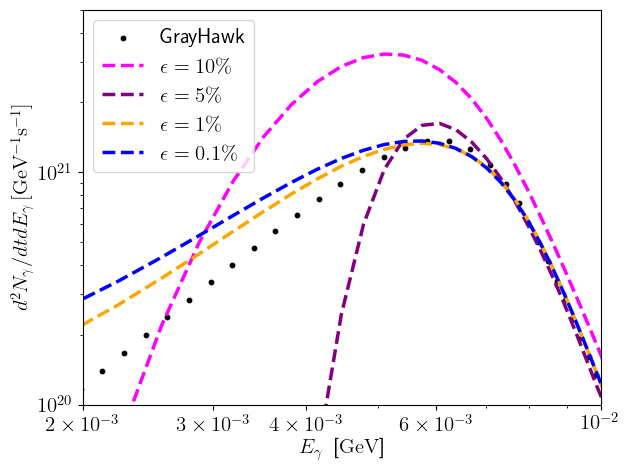

In [24]:
hplanck = 6.6260700404e-34  	#Joule*sec
hbar = hplanck/6.283185
clight = 299792458              #m/sec 
kb = 1.38064852e-23			    #Joule/K
G_Newtonian = 6.673*1e-11       #gravity, m^3/kg/s^2

J2GeV = 6.242*1e9               #Joule to GeV
K2GeV = 8.617*1e-14             #Kelvin to GeV
hbarGeV = hbar * J2GeV          #GeV * sec
Invhbar = 1.0/hbar              #Joule^-1*sec-1
InvhbarGeV = Invhbar / J2GeV

residual_cut = 0.25

def temperature(mass): #Hawking temperature, input unit is kg
    return hbar * clight**3 / (8 * np.pi * G_Newtonian * kb * mass) * K2GeV # kelvin to GeV

def energy(omega, mass):
    factor = hbar * clight**3 /(G_Newtonian*mass) * J2GeV  # GeV
    return omega * factor

def sum_gamma10(omega, mass):
    k0=1/4
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2*sum((2*(l+1) + 1) * s10_array[l] / (np.exp(2*np.pi*omega/k0) - 1) for l in range(4) )/(2*np.pi) 
    return result * InvhbarGeV

def spectra(omega, mass):
    temp = temperature(mass) #GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV 
    result = 2*sum((2*(l+1) + 1) * s10_array[l] / (np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV  


def manualfit(omega, l):
    a = -0.790
    b = -2.770
    c = 13.847
    hr = 0.5 * (erf(a + b*l + c*omega) + 1)   # model values
    nn = s10_array[:, l-1]   # numerical values

    residual = np.abs(nn-hr)/nn
    mask = np.cumsum(residual < residual_cut) < 0
    return  np.where(mask, 0, hr)  


def spectra_TP(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * manualfit(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV


#################################################################
def GBFsr01(x0, x1):
    return erf(erfc (-10.00055*x0 + 2*x1 + 1.08366))


def GBFsr1(x0, x1):
    return erf(erfc(1.097 + 2.059*x1 -10.293*x0 ) )

def GBFsr05(x0, x1):
    term1 = np.exp(-x0/0.0609 + x1/0.29925 )
    return erfc( term1 )

def GBFsr10(x0, x1):
    return erf(np.exp(3.8094 - x1/x0) )


def spectra_sr01(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * GBFsr01(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV


def spectra_sr1(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * GBFsr1(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV


def spectra_sr05(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * GBFsr05(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV


def spectra_sr10(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * GBFsr10(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV

###################################################################

schwarzschild_spectra = pd.read_csv("/Users/yuangw/Documents/GitHub/GBF/test/schwarzschild_spectra.csv", header=None, names=['x1', 'y1'])
x1 = schwarzschild_spectra['x1'].values
y1 = schwarzschild_spectra['y1'].values
energy_ini = np.logspace(np.log10(x1.min()), np.log10(x1.max()), 200)  # Define energy1 grid

plt.scatter(x1, y1, color='black', s=10, label='GrayHawk')
plt.plot(energy(s10x, 1e13), spectra_sr10(s10x, 1e13), color='magenta', linestyle='--', linewidth=2.5, label=r'$\epsilon=10\% $')
plt.plot(energy(s10x, 1e13), spectra_sr05(s10x, 1e13), color='purple', linestyle='--', linewidth=2.5, label=r'$\epsilon=5\% $')
plt.plot(energy(s10x, 1e13), spectra_sr1(s10x, 1e13), color='orange', linestyle='--', linewidth=2.5, label=r'$\epsilon=1\% $')
plt.plot(energy(s10x, 1e13), spectra_sr01(s10x, 1e13), color='blue', linestyle='--', linewidth=2.5, label=r'$\epsilon=0.1\% $')
plt.xscale("log")
plt.yscale("log")
plt.xlim(2e-3, 1e-2)
plt.ylim(1e20, 5e21)

plt.xticks([2.e-3, 3.e-3, 4.e-3, 6.e-3, 1.e-2], labels=[r'$2\times10^{-3}$', r'$3\times10^{-3}$', r'$4\times10^{-3}$', r'$6\times10^{-3}$', r'$10^{-2}$'])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel(r'$E_{\gamma}$\, [{\rm GeV}]', fontsize=15)
plt.ylabel(r'$d^2N_{\gamma}/dtdE_{\gamma}\, [\rm GeV^{-1}s^{-1}]$', fontsize=15)
# plt.title('Mass=10^13kg')
plt.legend(fontsize=15, loc ='upper left')

plt.tight_layout()
plt.savefig("sr_with_errors.pdf", bbox_inches='tight')
plt.show()